# Loss landscape toy task
The purpose of this notebook is to display the change in loss during a class-incremental task using a toy dataset with 4 classes.

In [1]:
import torch
import matplotlib.pyplot as plt
import models
import trainer
from dataloader.gpuLoading import GPUTensorDataset, GPUDataLoader
from optimizers import *
from models.layers.activation import Sign
from tqdm import tqdm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np


/home/kellian/micromamba/envs/binarized/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 999
DEVICE = "cuda:0"
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.set_default_device(DEVICE)
torch.set_default_dtype(torch.float32)

## Creating the dataset
The dataset will be composed of four classes, each one represented by a 2D Gaussian distribution. The classes will be created in a way that they are linearly separable.

In [3]:
# Let the dataset have 2 coordinates: x, y. The labels is either 0, 1, 2, 3. We generate a gaussian distribution for each label.

# Generate the dataset
n = 128
# first gaussian
gaussian1 = torch.randn(n, 2) * 0.3 + torch.tensor([5, 4])
# second gaussian
gaussian2 = torch.randn(n, 2) * 0.15 + torch.tensor([1.5, 2])
# third gaussian
gaussian3 = torch.randn(n, 2) * 0.2 + torch.tensor([4.5, 2.5])
# fourth gaussian
gaussian4 = torch.randn(n, 2) * 0.1 + torch.tensor([2, 4])
# Create dataset with labels respectively to each gaussian: 0, 1, 2, 3
dataset = torch.cat([gaussian1, gaussian2, gaussian3, gaussian4])
labels = torch.tensor([0] * n + [1] * n + [2] * n + [3] * n)

# Shuffle the dataset
perm = torch.randperm(4 * n)
dataset = dataset[perm]
labels = labels[perm]

# normalize the dataset between -1 and 1
dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())

# Training set and test set
split = 0.8
split = int(split * len(dataset))
train_dataset = dataset[:split]
train_labels = labels[:split]
test_dataset = dataset[split:]
test_labels = labels[split:]

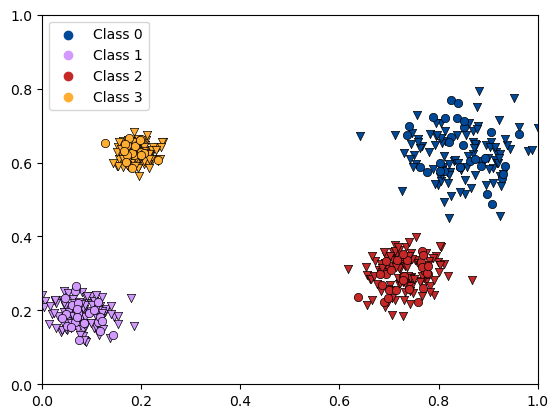

In [4]:
# Plot the train and the test dataset on the same graph with different colors and legend with respect to train and test

color_dict = ["#004999", "#d299ff", "#c62828", "#ffad33"]
# create cmap out of color_dict
for i in range(4):
    # train
    plt.scatter(train_dataset[train_labels == i, 0].cpu(), train_dataset[train_labels == i, 1].cpu(), color=color_dict[i], marker="v", linewidths=0.5, edgecolors="black")
    # test
    plt.scatter(test_dataset[test_labels == i, 0].cpu(), test_dataset[test_labels == i, 1].cpu(), color=color_dict[i], marker="o", linewidths=0.5, edgecolors="black")
for i in range(4):
    plt.scatter([], [], color=color_dict[i], label=f"Class {i}")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()

In [5]:
epochs = 500
layers = [16]
activation = torch.functional.F.relu
lr = 0.5
beta = 0
gamma = 0.5
num_samples_bp = 10
normalization="batchnorm"
running_stats=False
print(f"Bounds: ({lr/(1+gamma)},{lr/(1-beta)})")

Bounds: (0.3333333333333333,0.5)


In [6]:
# Split into 2 datasets of 2 classes each
train_x_t1 = train_dataset[train_labels < 2]
train_y_t1 = train_labels[train_labels < 2]
test_x_t1 = test_dataset[test_labels < 2]
test_y_t1 = test_labels[test_labels < 2]

# Split into 2 datasets of 2 classes each
train_x_t2 = train_dataset[train_labels >= 2]
train_y_t2 = train_labels[train_labels >= 2]
test_x_t2 = test_dataset[test_labels >= 2]
test_y_t2 = test_labels[test_labels >= 2]

# Convert into dataloader
train_dataset1 = GPUTensorDataset(train_x_t1, train_y_t1)
test_dataset1 = GPUTensorDataset(test_x_t1, test_y_t1)
train_dataset1 = GPUDataLoader(train_dataset1, batch_size=train_x_t1.shape[0], shuffle=True, drop_last=True)
test_dataset1 = GPUDataLoader(test_dataset1, batch_size=test_x_t1.shape[0], shuffle=False)

# Convert into dataloader
train_dataset2 = GPUTensorDataset(train_x_t2, train_y_t2)
test_dataset2 = GPUTensorDataset(test_x_t2, test_y_t2)
train_dataset2 = GPUDataLoader(train_dataset2, batch_size=train_x_t1.shape[0], shuffle=True, drop_last=True)
test_dataset2 = GPUDataLoader(test_dataset2, batch_size=test_x_t2.shape[0], shuffle=False)

train_dataset3 = GPUTensorDataset(train_dataset, train_labels)
test_dataset3 = GPUTensorDataset(test_dataset, test_labels)
train_dataset3 = GPUDataLoader(train_dataset3, batch_size=train_dataset.shape[0], shuffle=True, drop_last=True)
test_dataset3 = GPUDataLoader(test_dataset3, batch_size=test_dataset.shape[0], shuffle=False)

In [7]:
def plot_decision_boundary(trainer, test_dataset, test_labels, color_array, n_predictions=10):
    fig, ax = plt.subplots()
    
    # generate a similar grid but on the whole map
    x = torch.linspace(0, 1, 500)
    y = torch.linspace(0, 1, 500)
    xx, yy = torch.meshgrid(x, y)
    points = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)
    pred = trainer.predict(points, n_predictions)
    pred_mean = torch.stack(pred, dim=0).mean(dim=0).argmax(dim=1)
    
    # Plot one countourf per class with the color of the class
    for i in range(len(color_array)):
        ax.scatter(points[pred_mean == i, 0].cpu(), points[pred_mean == i, 1].cpu(), color=color_array[i], marker="o", alpha=0.7, s = 0.005)
  
  
    pred1= trainer.predict(test_dataset3.dataset.data, n_predictions)
    pred1_mean = torch.stack(pred1, dim=0).mean(dim=0)
    pred1_mean = pred1_mean.argmax(dim=1)
    x = test_dataset3.dataset.data.cpu()
    y = test_dataset3.dataset.targets.cpu()
    y_pred = pred1_mean.cpu()
    for i in range(len(color_array)):
        ax.scatter(x[y == i, 0], x[y == i, 1], color=color_array[i], marker="o", linewidths=0.35, edgecolors="black", s=25)
        ax.scatter(x[y_pred != y, 0], x[y_pred != y, 1], color="black", marker="v", s=25)
  
    # # PREDICTION
    # pred1 = trainer.predict(test_dataset1.dataset.data, n_predictions)
    # pred1_mean = torch.stack(pred1, dim=0).mean(dim=0)
    # #print(pred1_mean)
    # pred1_mean = pred1_mean.argmax(dim=1)
    
    # # Scatter of the test dataset with the color of the prediction
    # x = test_dataset1.dataset.data.cpu()
    # y = test_dataset1.dataset.targets.cpu()
    # y_pred = pred1_mean.cpu()
    # for i in [0, 1]:
    #     ax.scatter(x[y == i, 0], x[y == i, 1], color=color_array[i], marker="o", linewidths=0.35, edgecolors="black", s=25)
    #     ax.scatter(x[y_pred != y, 0], x[y_pred != y, 1], color="black", marker="v", s=25)

    # pred2 = trainer.predict(test_dataset2.dataset.data, n_predictions)
    # pred2_mean = torch.stack(pred2, dim=0).mean(dim=0).argmax(dim=1)
    # x2 = test_dataset2.dataset.data.cpu()
    # y2 = test_dataset2.dataset.targets.cpu()
    # y2_pred = pred2_mean.cpu()
    # # if y_pred != y, the color is the pink
    # # else the color is the color of the class
    # for i in [2, 3]:
    #     ax.scatter(x2[y2 == i, 0], x2[y2 == i, 1], color=color_array[i], marker="o", linewidths=0.35, edgecolors="black", s=25)
    #     ax.scatter(x2[y2_pred != y2, 0], x2[y2_pred != y2, 1], color="black", marker="v", s=25)
    plt.legend(loc='upper left')
    plt.plot()
    plt.show()


In [8]:
def plot_loss(loss_array):
    plt.plot(loss_array)
    plt.xlabel("Epochs [-]")
    plt.ylabel("Training loss [-]")
    plt.show()

In [9]:
def train_model(train_loader, test_loader, lr, beta, gamma, num_samples_bp, layers, activation, normalization, running_stats):
    SEED = 999
    DEVICE = "cuda:0"
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    torch.set_default_device(DEVICE)
    torch.set_default_dtype(torch.float32)
    model = models.BiNN(
        layers=[2] + layers + [4],
        device=DEVICE,
        dropout=False,
        init="uniform",
        std=0.01,
        bias=False,
        latent_weights=False,
        activation_function=activation,
        output_function="softmax",
        normalization=normalization,
        momentum=0,
        eps=1e-08,
        running_stats=running_stats,
        affine=False,
    )
    
    optimizer = BinaryHomosynapticUncertaintyTest
    optimizer_params = {
    "lr": lr,
    "beta": beta,
    "gamma": gamma,
    "num_mcmc_samples": num_samples_bp,
    "init_law": "uniform",
    "init_param": 0,
    "norm": False,
    "debug": False,
    }
    loss = torch.functional.F.cross_entropy

    bayes_train = trainer.BayesTrainer(
    model = model,
    optimizer = optimizer,
    optimizer_parameters = optimizer_params,
    criterion = loss,
    device = DEVICE,
    test_mcmc_samples = 1, )
    for train in train_loader:
        loss_array = []
        pbar = tqdm(range(epochs))
        for epoch in pbar:
            bayes_train.epoch_step(train)
            bayes_train.evaluate(test_loader, train_loader=train_loader)
            if epoch % 10 == 0:
                pbar.set_description(f"Loss: {bayes_train.loss.item():.2f}")
            loss_array.append(bayes_train.loss.item())
        plot_loss(loss_array)
        plot_decision_boundary(bayes_train, test_dataset, test_labels, color_dict)
        for i, _ in enumerate(train_loader):
            print(f"Train: {bayes_train.training_accuracy[-1][i].item()*100:.2f}%")
        print(f"Test: {bayes_train.testing_accuracy[-1][0].item()*100:.2f}%")

Loss: 230.96: 100%|██████████| 500/500 [00:04<00:00, 121.44it/s]


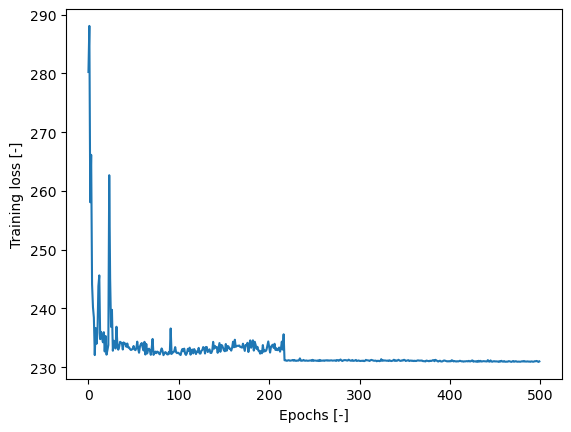

/home/kellian/micromamba/envs/binarized/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035629/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
No handles with labels found to put in legend.


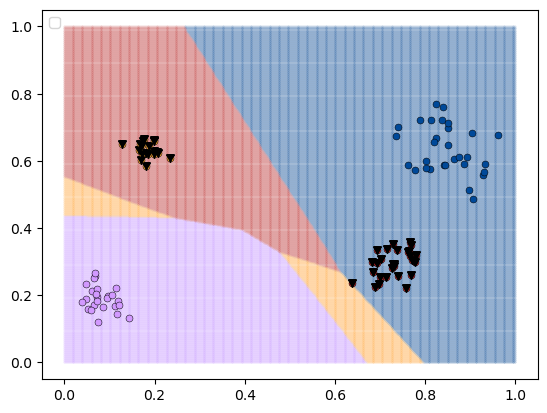

Train: 70.15%
Train: 3.48%
Test: 53.40%


Loss: 274.73: 100%|██████████| 500/500 [00:04<00:00, 122.85it/s]


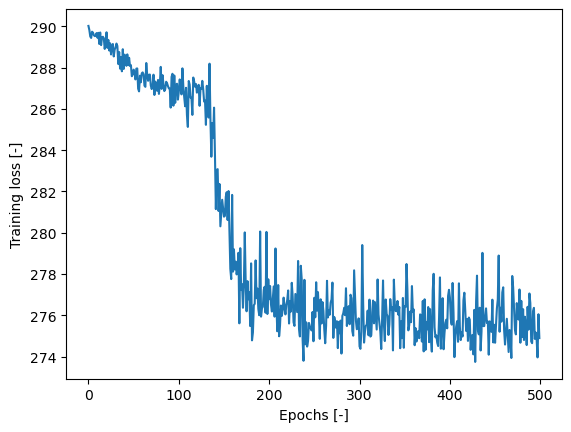

No handles with labels found to put in legend.


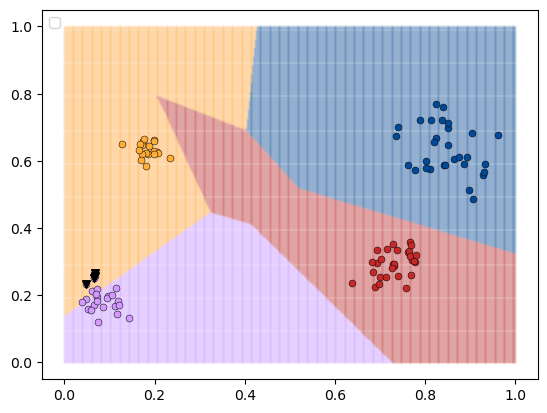

Train: 73.13%
Train: 50.75%
Test: 99.03%


In [10]:
train_loader = [train_dataset1, train_dataset2]
test_loader = [test_dataset3]
train_model(train_loader, test_loader, lr, beta, gamma, num_samples_bp, layers, activation, normalization, running_stats)

In [11]:
# bayes_train.optimizer.state["lambda"]
# # plot histogram of lambdas
# hist = torch.histc(bayes_train.optimizer.state["lambda"], bins=100, min = -10, max = 10)
# plt.bar(torch.linspace(-10, 10, 100).cpu(), hist.cpu()/hist.sum().cpu(), width=0.2)
# plt.show()

In [12]:
epochs = 500
layers = [16]
activation = torch.functional.F.relu
lr = 1.5
beta = 0
gamma = 0
num_samples_bp = 10
normalization="batchnorm"
running_stats=False
print(f"Bounds: ({lr/(1+gamma)},{lr/(1-beta)})")

Bounds: (1.5,1.5)


Loss: 386.76: 100%|██████████| 500/500 [00:03<00:00, 134.14it/s]


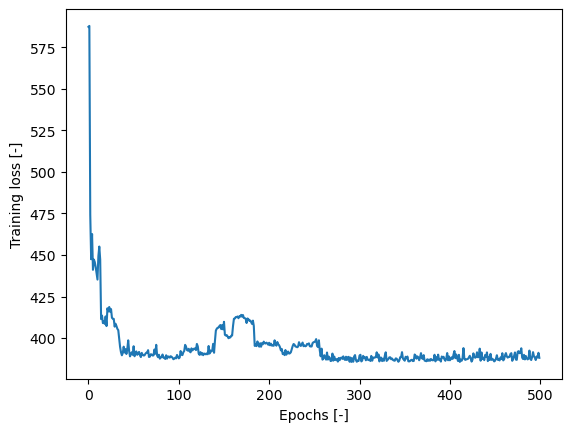

No handles with labels found to put in legend.


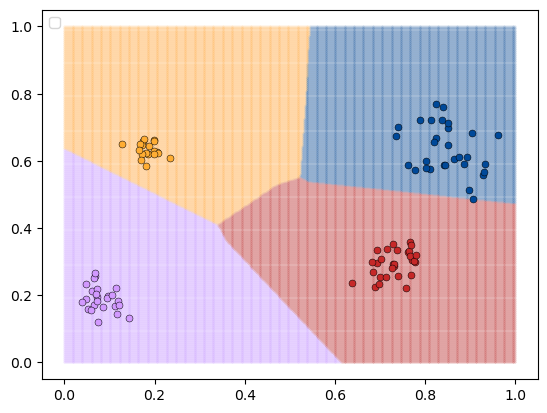

Train: 99.51%
Test: 100.00%


In [13]:
train_model([train_dataset3], [test_dataset3], lr, beta, gamma, num_samples_bp, layers, activation, normalization, running_stats)